# **Automatidata Project**

#### **Index** 

1. [To 05_Build a Machine Learning Model](#section_05)

#### **05_Build a Machine Learning Model** <a id='section_05'></a>

**Additional part:** New York City Taxi & Limousine Commission (New York City TLC) requested Automatidata to `build a machine learning model to predict a generous customer who likely to leave a tip`. They want to use the model in an app that will alert taxi drivers to customers who are unlikely to tip, since drivers depend on tips.

1. Understand the situation
    - Understand stakeholder request and mission
    - Understand provided taxi cab dataset and information
2. Understand the data
    - Since the data has been cleaned up from the previous activity, this process has been simplfied
    - Combine the existing base data with the new provided data related to this sub-project
3. Understand the variables
    - Use insights from the examination of the summary data to guide deeper investigation into specific variables.

In [1]:
# Import necessary libaries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

In [2]:
# Display all columns
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

Begin by re-examining the exsisting data and examining provided new data. The new data is the prediction fares from the previous main project.

In [3]:
# Load dataset into dataframe
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration from previous course
nyc_preds_means = pd.read_csv('nyc_preds_means.csv')

In [4]:
# Inspect the first 10 rows of df3
df0.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36
6,37660487,2,05/03/2017 7:04:09 PM,05/03/2017 8:03:47 PM,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.0,0.3,59.16
7,69059411,2,08/15/2017 5:41:06 PM,08/15/2017 6:03:05 PM,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.0,0.3,19.58
8,8433159,2,02/04/2017 4:17:07 PM,02/04/2017 4:29:14 PM,1,1.20,1,N,234,249,2,9.0,0.0,0.5,0.00,0.0,0.3,9.80
9,95294817,1,11/10/2017 3:20:29 PM,11/10/2017 3:40:55 PM,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.0,0.3,16.55


In [5]:
# Inspect the first 10 rows of `nyc_preds_means`
nyc_preds_means.head(10)

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642
5,11.855376,2.052258,10.441351
6,59.633333,12.830000,45.374542
7,26.437500,4.022500,18.555128
8,7.873457,1.019259,7.151511
9,10.541111,1.580000,9.122755


In [6]:
# Merge datasets and list out first 10 rows
df0 = df0.merge(nyc_preds_means, left_index=True, right_index=True)
df0.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351
6,37660487,2,05/03/2017 7:04:09 PM,05/03/2017 8:03:47 PM,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.0,0.3,59.16,59.633333,12.830000,45.374542
7,69059411,2,08/15/2017 5:41:06 PM,08/15/2017 6:03:05 PM,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.0,0.3,19.58,26.437500,4.022500,18.555128
8,8433159,2,02/04/2017 4:17:07 PM,02/04/2017 4:29:14 PM,1,1.20,1,N,234,249,2,9.0,0.0,0.5,0.00,0.0,0.3,9.80,7.873457,1.019259,7.151511
9,95294817,1,11/10/2017 3:20:29 PM,11/10/2017 3:40:55 PM,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.0,0.3,16.55,10.541111,1.580000,9.122755


In [7]:
# Examine the merge dataset
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In [8]:
# Subset the data to isolate only customers who paid by credit card
df1 = df0[df0['payment_type']==1]
df1.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.00,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.00,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.00,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.00,0.3,27.69,30.250000,3.700000,18.731650
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.00,0.3,12.36,11.855376,2.052258,10.441351
6,37660487,2,05/03/2017 7:04:09 PM,05/03/2017 8:03:47 PM,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.00,0.3,59.16,59.633333,12.830000,45.374542
7,69059411,2,08/15/2017 5:41:06 PM,08/15/2017 6:03:05 PM,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.00,0.3,19.58,26.437500,4.022500,18.555128
9,95294817,1,11/10/2017 3:20:29 PM,11/10/2017 3:40:55 PM,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.00,0.3,16.55,10.541111,1.580000,9.122755
10,18017909,2,03/04/2017 11:58:00 AM,03/04/2017 12:13:12 PM,1,1.77,1,N,162,142,1,11.5,0.0,0.5,2.46,0.00,0.3,14.76,14.178333,1.641000,10.147760
11,18600059,2,03/05/2017 7:15:30 PM,03/05/2017 7:52:18 PM,2,18.90,2,N,236,132,1,52.0,0.0,0.5,14.58,5.54,0.3,72.92,40.500000,19.211667,52.000000


In [9]:
# Create tip percentage column
df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)
df1.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.00,0.3,16.56,22.847222,3.521667,16.434245,0.200
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.00,0.3,20.80,24.470370,3.108889,16.052218,0.238
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.00,0.3,8.75,7.250000,0.881429,7.053706,0.199
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.00,0.3,27.69,30.250000,3.700000,18.731650,0.300
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.00,0.3,12.36,11.855376,2.052258,10.441351,0.200
6,37660487,2,05/03/2017 7:04:09 PM,05/03/2017 8:03:47 PM,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.00,0.3,59.16,59.633333,12.830000,45.374542,0.200
7,69059411,2,08/15/2017 5:41:06 PM,08/15/2017 6:03:05 PM,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.00,0.3,19.58,26.437500,4.022500,18.555128,0.100
9,95294817,1,11/10/2017 3:20:29 PM,11/10/2017 3:40:55 PM,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.00,0.3,16.55,10.541111,1.580000,9.122755,0.199
10,18017909,2,03/04/2017 11:58:00 AM,03/04/2017 12:13:12 PM,1,1.77,1,N,162,142,1,11.5,0.0,0.5,2.46,0.00,0.3,14.76,14.178333,1.641000,10.147760,0.200
11,18600059,2,03/05/2017 7:15:30 PM,03/05/2017 7:52:18 PM,2,18.90,2,N,236,132,1,52.0,0.0,0.5,14.58,5.54,0.3,72.92,40.500000,19.211667,52.000000,0.250


Continue by creating a new target column, called `generous`. This column should be a binary indicator of whether or not customer tipped ≥ 20%.

`(0 = No, 1 = Yes)`

Next, we are going to be working with `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns.

In [10]:
# Create 'generous' column (target)
df1['generous'] = df1['tip_percent']
df1['generous'] = (df1['generous'] >= 0.2)
df1['generous'] = df1['generous'].astype(int)

In [11]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format = '%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format = '%m/%d/%Y %I:%M:%S %p')

In [12]:
#Re-examine dataset
df1.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.00,0.3,16.56,22.847222,3.521667,16.434245,0.200,1
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.00,0.3,20.80,24.470370,3.108889,16.052218,0.238,1
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.00,0.3,8.75,7.250000,0.881429,7.053706,0.199,0
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.00,0.3,27.69,30.250000,3.700000,18.731650,0.300,1
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.00,0.3,12.36,11.855376,2.052258,10.441351,0.200,1
6,37660487,2,2017-05-03 19:04:09,2017-05-03 20:03:47,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.00,0.3,59.16,59.633333,12.830000,45.374542,0.200,1
7,69059411,2,2017-08-15 17:41:06,2017-08-15 18:03:05,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.00,0.3,19.58,26.437500,4.022500,18.555128,0.100,0
9,95294817,1,2017-11-10 15:20:29,2017-11-10 15:40:55,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.00,0.3,16.55,10.541111,1.580000,9.122755,0.199,0
10,18017909,2,2017-03-04 11:58:00,2017-03-04 12:13:12,1,1.77,1,N,162,142,1,11.5,0.0,0.5,2.46,0.00,0.3,14.76,14.178333,1.641000,10.147760,0.200,1
11,18600059,2,2017-03-05 19:15:30,2017-03-05 19:52:18,2,18.90,2,N,236,132,1,52.0,0.0,0.5,14.58,5.54,0.3,72.92,40.500000,19.211667,52.000000,0.250,1


In [13]:
# Create a 'day' column
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

We then proceed to feature engineer 4 new columns that represent time of day bins. Each column should contain binary information that indicate whether a trip began (tpep_pickup_datatime) during the following times:

1. `am_rush`   = 06:00 - 10:00
2. `daytime`   = 10:00 - 16:00
3. `pm_rush`   = 16:00 - 20:00
4. `nighttime` = 20:00 - 06:00 

In [14]:
# Insert the hour from the `tpep_pickup_datetime` into each column
# Create 'am_rush' col
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

# Inspect the data
df1.head(3)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,8,8,8,8
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,14,14,14,14
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,7,7,7,7


In [15]:
# Define 'am_rush()' conversion function [06:00–10:00]
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

In [16]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,1,8,8,8
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,0,14,14,14
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,1,7,7,7
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,0,13,13,13
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,0,20,20,20


In [17]:
# Define 'daytime()' conversion function [10:00–16:00]
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

# Define 'pm_rush()' conversion function [16:00–20:00]
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

# Define 'nighttime()' conversion function [20:00–06:00]
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [18]:
# Apply 'daytime', 'pm_rush' and 'nighttime' function to the 'daytime' series
df1['daytime'] = df1.apply(daytime, axis=1)
df1['pm_rush'] = df1.apply(pm_rush,  axis=1)
df1['nighttime'] = df1.apply(nighttime, axis=1)
df1.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,1,0,0,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,0,1,0,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,1,0,0,0
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,0,1,0,0
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,0,0,0,1


In [19]:
# Create 'month' column
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()
df1.head(3)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,1,0,0,0,dec


In [20]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             15265 non-null  int64         
 1   VendorID               15265 non-null  int64         
 2   tpep_pickup_datetime   15265 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  15265 non-null  datetime64[ns]
 4   passenger_count        15265 non-null  int64         
 5   trip_distance          15265 non-null  float64       
 6   RatecodeID             15265 non-null  int64         
 7   store_and_fwd_flag     15265 non-null  object        
 8   PULocationID           15265 non-null  int64         
 9   DOLocationID           15265 non-null  int64         
 10  payment_type           15265 non-null  int64         
 11  fare_amount            15265 non-null  float64       
 12  extra                  15265 non-null  float64       
 13  mta_ta

In [21]:
# Drop redudndant and irrelevant columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int32  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int32(1), int64(9), object(2)
memory usage: 1.8+ MB


`RatecodeID`, `PULocationID`, `DOLocationID` and `VendorID` are categorical columns and need to be dummies eventhough they are numeric. We have to convert them `type(str)` before do the variable encoding.

In [22]:
# Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')
    
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  object 
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  object 
 3   PULocationID     15265 non-null  object 
 4   DOLocationID     15265 non-null  object 
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int32  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int32(1), int64(5), object(6)
memory usage: 1.8+ MB


In [23]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to month_sep
dtypes: bool(338), float64(3), int32(1), int64(5)
memory usage: 6.0 MB


In [24]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize = True)

generous
1    0.526368
0    0.473632
Name: proportion, dtype: float64

In [25]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis = 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

##### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more we tune, the better our model will fit the data, but the longer it will take. 
 - `max_depth`  
 - `max_features`  
 - `max_samples` 
 - `min_samples_leaf`  
 - `min_samples_split`
 - `n_estimators`  

3. Define a set `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf1`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds we want (`cv=_`)
 - refit: indicate which evaluation metric we want to use to select the model (`refit=_`)

 **Note:** `refit` should be set to `'f1'`

In [26]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state = 42)

# 2. Create a dictionary of hyperparameters to tune 
# Note that this example only contains 1 value for each parameter for simplicity, but we should assign a dictionary with ranges of values
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

# 3. Define a set of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf1 = GridSearchCV(rf, cv_params, scoring = scoring, cv = 4, refit = 'f1')

In [32]:
# Fit the model
rf1.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [54]:
import pickle 

# Define a path to the folder where we want to save the model
path = 'C:/Users/r14fadhli/Desktop/#RoadToDataScientist/Github/Automatica/'

In [28]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [29]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [76]:
# Save the model to a file
write_pickle(path, rf1, "RandomForestClassifier")

In [31]:
read_pickle(path, "RandomForestClassifier")

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [33]:
# Examine best score
rf1 = read_pickle(path, "RandomForestClassifier")
rf1.best_score_

0.7136009788848705

In [34]:
# Examine the best combination of hyperparameters
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [35]:
# Create make_results() function to output all the scores of built model
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what we want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [36]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233


In [37]:
# Get scores on test data
rf_preds = rf1.best_estimator_.predict(X_test)

In [53]:
# Use the below get_test_scores() function to output the scores of the model using the test data
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for our model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [39]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233
0,RF test,0.675297,0.779091,0.723490,0.686538


##### **XGBoost**

 Try to improve the scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a set `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds we want (`cv=_`)
 - refit: indicate which evaluation metric we want to use to select the model (`refit='f1'`)

In [42]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but we should assign a dictionary with ranges of values
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

# 3. Define a set of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

In [43]:
# Fit the model
xgb1.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [44]:
# Examine best score
xgb1.best_score_

0.6955124635485908

In [45]:
# Examine best parameters
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

In [46]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233
0,RF test,0.675297,0.779091,0.723490,0.686538
0,XGB CV,0.669726,0.723553,0.695512,0.666557


In [47]:
# Get scores on test data
xgb_preds = xgb1.best_estimator_.predict(X_test)

In [48]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.674919,0.757312,0.713601,0.680233
0,RF test,0.675297,0.779091,0.723490,0.686538
0,XGB CV,0.669726,0.723553,0.695512,0.666557
0,XGB test,0.677219,0.745488,0.709716,0.679004


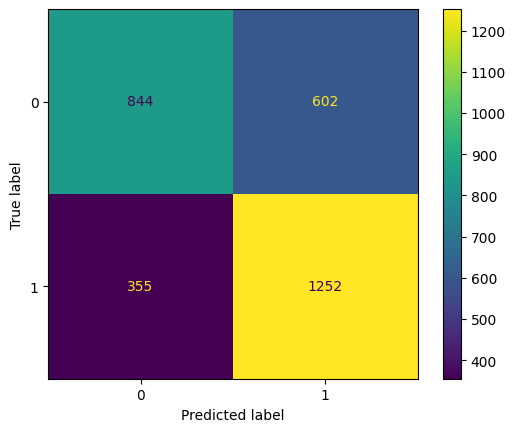

In [50]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf1.classes_, )
disp.plot(values_format='');

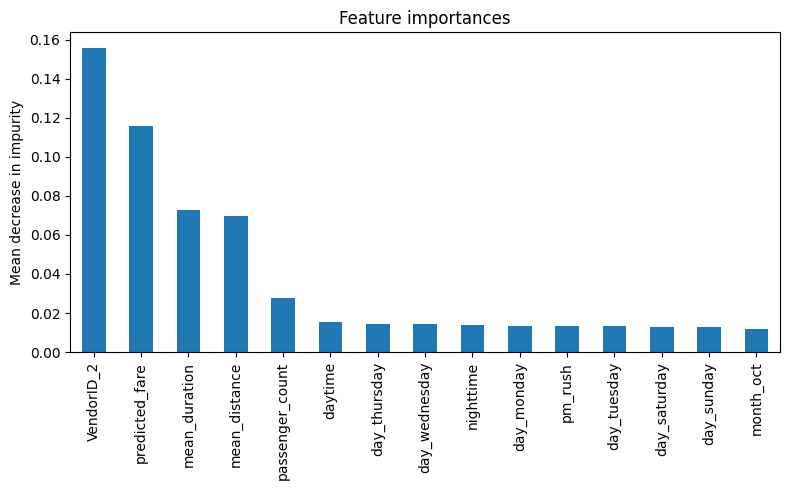

In [51]:
# Use feature_importances_ attribute of the best estimator object to inspect the features of the final model
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();